# Analysis of Datetime Bugs

In [ ]:
# Install dependencies if missing
%pip install matplotlib
%pip install seaborn
%pip install pandas
%pip install wordcloud

In [58]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

SAVE_PATH = "./visualizations/"

# Read the data from the TSV file
df = pd.read_csv('./data/bugs_analysis_base_processed+grouped.tsv', sep='\t')
print("Total number of datapoints: ", len(df))
df.head()

Total number of datapoints:  152


,Owner,Project,Title,Link,Fix Link,Stars,TF-IDFs,Size,Datetime,Arrow,...,Erroneous Computation 1,Erroneous Computation 2,Erroneous Computation 3,Obscurity,Impact,# LOC,Logic Needed,Bug Pattern 1,Bug Pattern 2,Bug Pattern 3
0,python-poetry,tomlkit,datetime.utcnow and datetime.utcfromtimestamp ...,https://github.com/python-poetry/tomlkit/issue...,https://github.com/python-poetry/tomlkit/commi...,643.0,1.312623,1001.0,1.0,0.0,...,Datetime (Construction),NaN,NaN,Low,Low,Low,Low,Outdated/Deprecated APIs,NaN,NaN
1,frictionlessdata,frictionless-py,SpssParser ignores timezones,https://github.com/frictionlessdata/frictionle...,https://github.com/frictionlessdata/frictionle...,683.0,1.270077,1279.0,1.0,0.0,...,Datetime (Construction),String (Parsing and Formatting),NaN,Low,Medium,Medium,High,Dropping Timezones,NaN,NaN
2,sdispater,pendulum,Deepcopy of Month-based Duration produces a di...,https://github.com/sdispater/pendulum/issues/714,https://github.com/sdispater/pendulum/commit/9...,6109.0,1.191295,1014.0,1.0,0.0,...,Delta (Construction and Arithmetic),NaN,NaN,Medium,Medium,Medium,Low,Unintuitive Arithmetic,NaN,NaN
3,googleapis,python-storage,`DeprecationWarning` warning in build log for ...,https://github.com/googleapis/python-storage/i...,https://github.com/googleapis/python-storage/c...,420.0,1.176351,10349.0,1.0,0.0,...,Datetime (Arithmetic),NaN,NaN,Low,Low,Low,Low,Outdated/Deprecated APIs,NaN,NaN
4,googleapis,python-logging,`DeprecationWarning` warning in build log for ...,https://github.com/googleapis/python-logging/i...,https://github.com/googleapis/python-logging/p...,119.0,1.167279,2673.0,1.0,0.0,...,Datetime (Construction),NaN,NaN,Low,Low,Low,Low,Outdated/Deprecated APIs,NaN,NaN


df.columns
"""
Index(
       ['Owner', 'Project', 'Title', 'Stars', 'TF-IDFs', 'Size', 'Datetime',
       'Arrow', 'Pendulum', 'Description', 'Category 1', 'Category 2',
       'Erroneous Computation 1', 'Erroneous Computation 2',
       'Bug Pattern 3', 'Obscurity', 'Impact/Severity', '# LOC',
       'Logic Needed', 'Comments', 'BPST1', 'BPST2', 'BPST3'],
dtype='object')
"""

## What are the highlevel terms used to describe date and time bugs?

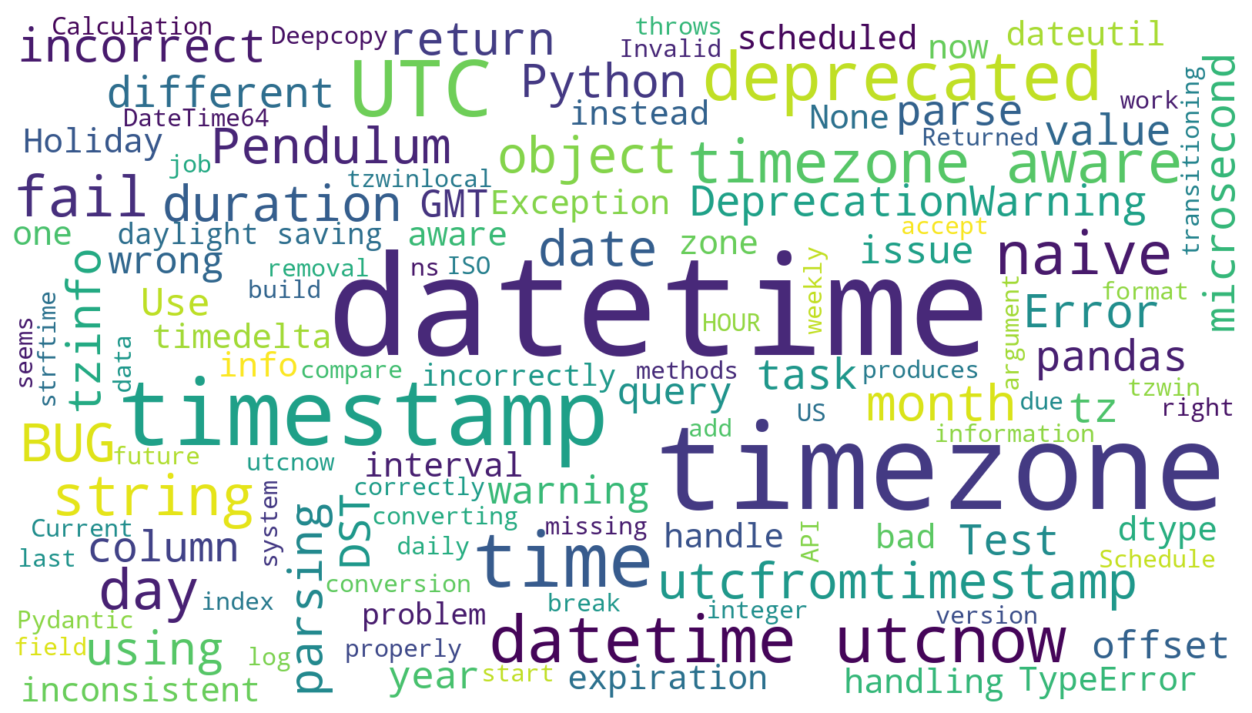

In [49]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

# 1. Combine all text from the column into a single string
text = ' '.join(df['Title'].astype(str))

# 2. Create a WordCloud object
wordcloud = WordCloud(
    width=1600, 
    height=900, 
    max_font_size=180,
    max_words=120,
    background_color="white",
    colormap='viridis',
    # mask=datetime_mask,
    contour_width=1,
    ).generate(text)

# 3. Display the generated image
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(SAVE_PATH+'wordcloud.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Stats about bug obscurity/impact and fix complexity/#loc

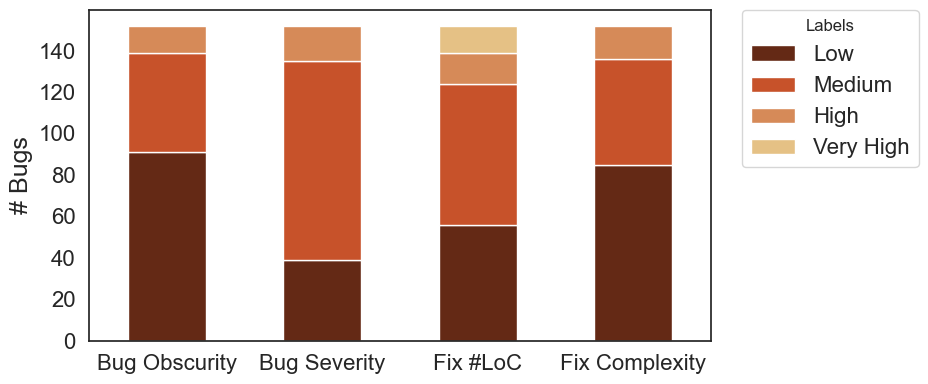

In [59]:
# Define the colors for the bar chart
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
sns.set_theme(style='white')

# select only specific columns
df_new = df[['# LOC', 'Logic Needed', 'Obscurity', 'Impact']]

# Count occurrences for each category in each column
loc_counts = df_new['# LOC'].value_counts()
logic_counts = df_new['Logic Needed'].value_counts()
obscurity_counts = df_new['Obscurity'].value_counts()
impact_counts = df_new['Impact'].value_counts()

# Ensure all categories are in the same order
categories = ['Low', 'Medium', 'High', 'Very High']
loc_counts = loc_counts.reindex(categories, fill_value=0)
logic_counts = logic_counts.reindex(categories, fill_value=0)
obscurity_counts = obscurity_counts.reindex(categories, fill_value=0)
impact_counts = impact_counts.reindex(categories, fill_value=0)

# Compose the data for a stacked bar chart
stacked_data = pd.DataFrame({
    'Bug Obscurity': obscurity_counts,
    'Bug Severity': impact_counts,
    'Fix #LoC': loc_counts,
    'Fix Complexity': logic_counts,
}, index=categories)
stacked_data.head()

# transpose the data for plotting
stacked_data = stacked_data.T
stacked_data.head()

# Plotting
ax = stacked_data.plot(kind='bar', stacked=True, color=colors[:4], figsize=(12, 4), width=0.5)

# Place legend outside the plot
ax.legend(title='Labels', fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Set labels and layout
plt.ylabel('# Bugs', fontsize=18)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])

# Save and show the plot
plt.savefig(SAVE_PATH + 'stacked_bar_chart.pdf', transparent=True, bbox_inches='tight')
plt.show()

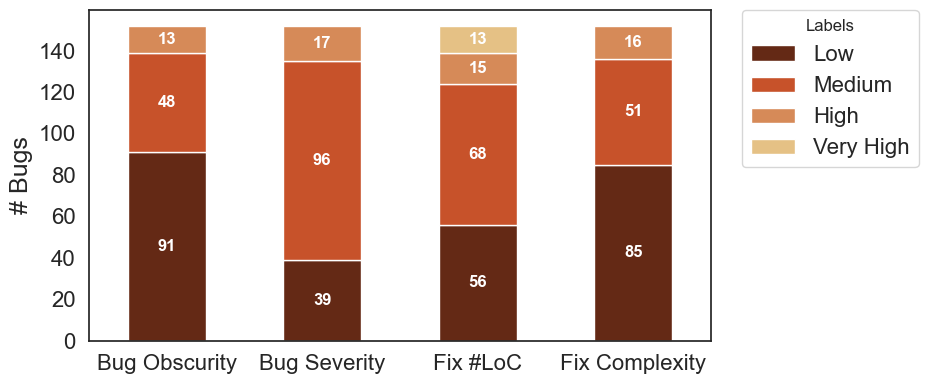

In [60]:
# Define the colors for the bar chart
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
sns.set_theme(style='white')

# select only specific columns
df_new = df[['# LOC', 'Logic Needed', 'Obscurity', 'Impact']]

# Count occurrences for each category in each column
loc_counts = df_new['# LOC'].value_counts()
logic_counts = df_new['Logic Needed'].value_counts()
obscurity_counts = df_new['Obscurity'].value_counts()
impact_counts = df_new['Impact'].value_counts()

# Ensure all categories are in the same order
categories = ['Low', 'Medium', 'High', 'Very High']
loc_counts = loc_counts.reindex(categories, fill_value=0)
logic_counts = logic_counts.reindex(categories, fill_value=0)
obscurity_counts = obscurity_counts.reindex(categories, fill_value=0)
impact_counts = impact_counts.reindex(categories, fill_value=0)

# Compose the data for a stacked bar chart
stacked_data = pd.DataFrame({
    'Bug Obscurity': obscurity_counts,
    'Bug Severity': impact_counts,
    'Fix #LoC': loc_counts,
    'Fix Complexity': logic_counts,
}, index=categories)

# Transpose the data for plotting
stacked_data = stacked_data.T

# Plotting
ax = stacked_data.plot(kind='bar', stacked=True, color=colors[:4], figsize=(12, 4), width=0.5)

# Iterate over each column in the DataFrame and display the value on the bars
for i, bar in enumerate(ax.containers):
    # Use ax.bar_label() in case of Matplotlib >= 3.4
    ax.bar_label(bar, label_type='center', fontsize=12, color='white', fontweight='bold', labels=['' if v==0 else int(v) for v in bar.datavalues])
    # ax.bar_label(bar, label_type='center', fontsize=12, color='white', labels=['' if v==0 else int(v) for v in bar.datavalues])

# Place legend outside the plot
ax.legend(title='Labels', fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Set labels and layout
plt.ylabel('# Bugs', fontsize=18)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])

# Save and show the plot
plt.savefig(SAVE_PATH + 'stacked_bar_chart.pdf', transparent=True, bbox_inches='tight')
plt.show()

## What are the most common causes of bugs?
### Plot the Broad Categories.

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_2911/3910458479.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_2911/3910458479.py:30: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)


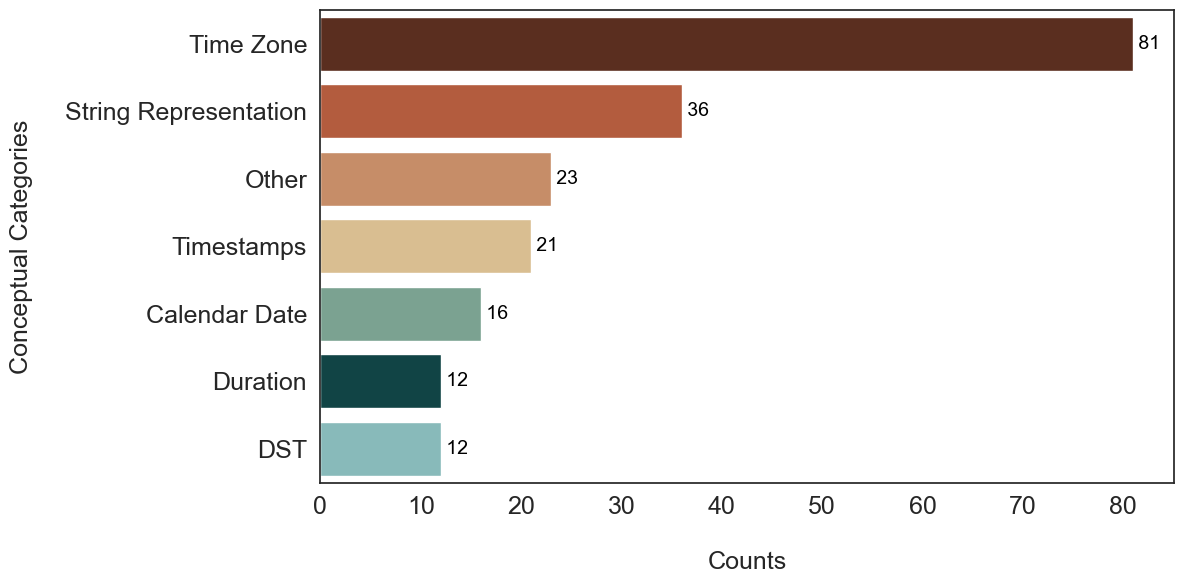

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_2911/3910458479.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_2911/3910458479.py:67: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)


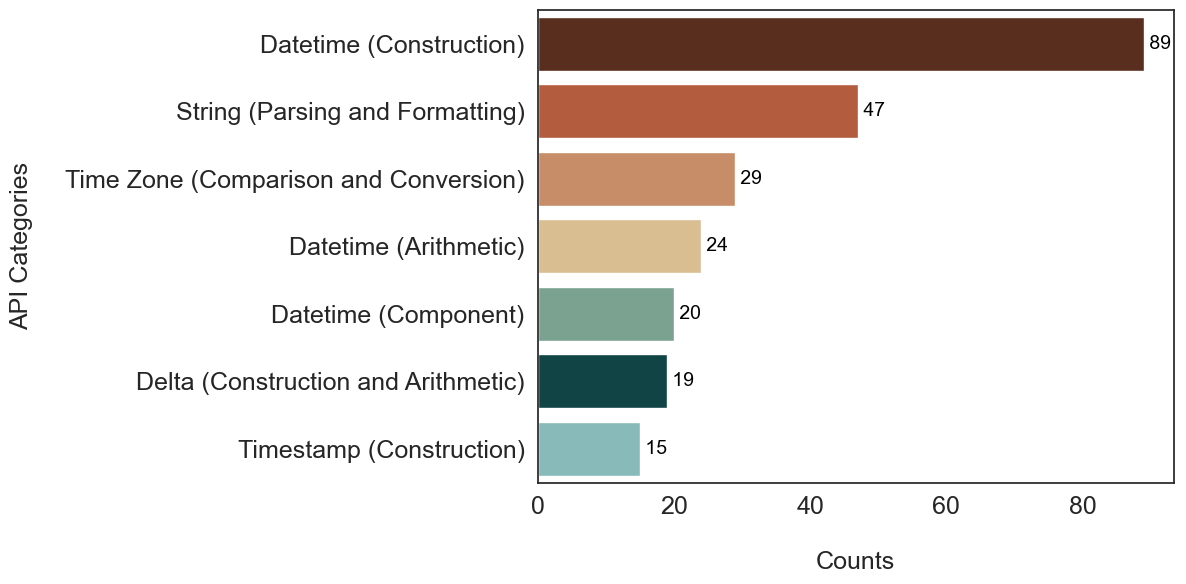

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_2911/3910458479.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_2911/3910458479.py:105: UserWarning: 
The palette list has fewer values (8) than needed (13) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)


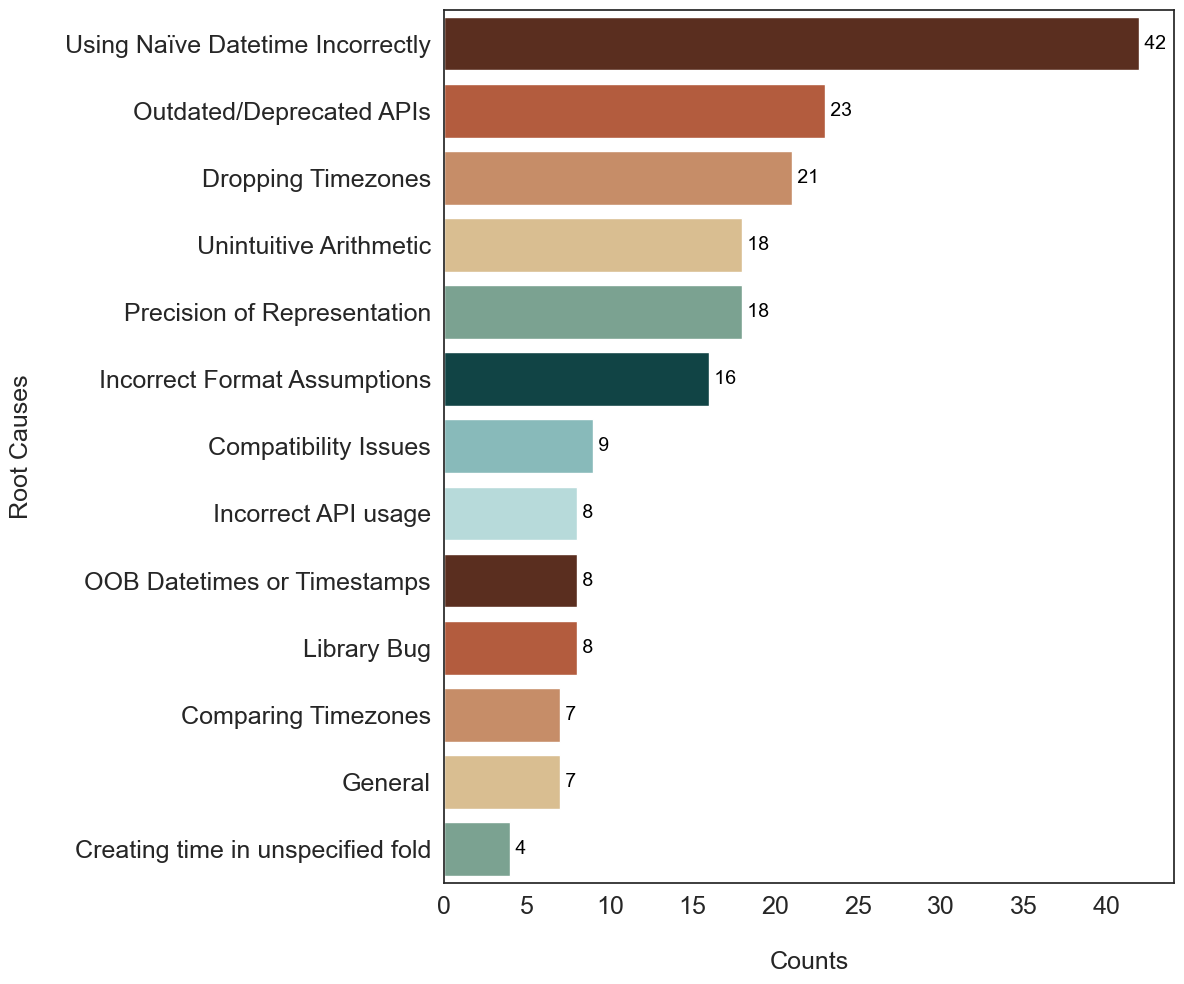

In [61]:
# Define the colors for the bar chart
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
sns.set_theme(style='white')

#######################################################################################

# Conceptual Categories
# Merge both categories into one Series
combined_categories = pd.concat([df['Category 1'], df['Category 2']])

# Count occurrences of each category
category_counts = combined_categories.value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort DataFrame by Count
category_counts = category_counts.sort_values("Count", ascending=False)

# Plotting
# plt.figure(figsize=(12, 6))
# ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
# ax.set_xlabel('\nCounts', fontsize=18)
# ax.set_ylabel('Conceptual Categories\n', fontsize=18)
# ax.tick_params(axis='y', labelsize=18)  # Use this to control y-tick label sizes
# ax.tick_params(axis='x', labelsize=18)  # Use this to control x-tick label sizes

# plt.savefig(SAVE_PATH + 'conceptual_categories.pdf', bbox_inches='tight')
# plt.show()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)

# Add annotations
for index, row in category_counts.iterrows():
    ax.text(row.Count, index, f' {row.Count} ', color='black', ha="left", va="center", fontsize=14)

# Set labels and titles
ax.set_xlabel('\nCounts', fontsize=18)
ax.set_ylabel('Conceptual Categories\n', fontsize=18)
ax.tick_params(axis='y', labelsize=18)  # Use this to control y-tick label sizes
ax.tick_params(axis='x', labelsize=18)  # Use this to control x-tick label sizes

plt.tight_layout()
plt.savefig(SAVE_PATH + 'conceptual_categories.pdf', bbox_inches='tight')
plt.show()

#######################################################################################


# What are the most common Erroneous Computations?
timezone_df = df.copy()

# Merge all Erroneous Computation columns into one Series
combined_categories = pd.concat([timezone_df['Erroneous Computation 1'], 
                                 timezone_df['Erroneous Computation 2'], 
                                 timezone_df['Erroneous Computation 3']])
combined_categories = combined_categories.dropna()

# Count occurrences of each category
category_counts = combined_categories.value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort DataFrame by Count
category_counts = category_counts.sort_values("Count", ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)

# Add annotations
for index, row in category_counts.iterrows():
    ax.text(row.Count, index, f' {row.Count} ', color='black', ha="left", va="center", fontsize=14)

# Set labels and titles
ax.set_xlabel('\nCounts', fontsize=18)
ax.set_ylabel('API Categories\n', fontsize=18)
ax.tick_params(axis='y', labelsize=18)  # Use this to control y-tick label sizes
ax.tick_params(axis='x', labelsize=18)  # Use this to control x-tick label sizes

plt.tight_layout()
plt.savefig(SAVE_PATH + 'api_categories.pdf', bbox_inches='tight')
plt.show()


#######################################################################################


# What are the most common Bugs?
timezone_df = df.copy()

# Merge Bug Patterns into one Series
combined_categories = pd.concat([timezone_df['Bug Pattern 1'], 
                                 timezone_df['Bug Pattern 2'], 
                                 timezone_df['Bug Pattern 3']])
combined_categories = combined_categories.dropna()

# Count occurrences of each category
category_counts = combined_categories.value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort DataFrame by Count
category_counts = category_counts.sort_values("Count", ascending=False)

# Plotting
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)

# Add numerical annotations on each bar
for index, row in category_counts.iterrows():
    ax.text(row.Count, index, f' {row.Count} ', color='black', ha='left', va='center', fontsize=14)

# Set labels and titles
ax.set_xlabel('\nCounts', fontsize=18)
ax.set_ylabel('Root Causes\n', fontsize=18)
ax.tick_params(axis='y', labelsize=18)  # Manage y-tick label sizes
ax.tick_params(axis='x', labelsize=18)  # Manage x-tick label sizes

plt.tight_layout()
plt.savefig(SAVE_PATH + 'root_causes.pdf', bbox_inches='tight')
plt.show()

     Bug Obscurity  Bug Severity  Fix #LoC  Fix Complexity
0                1             1         1               1
1                1             2         2               3
2                2             2         2               1
3                1             1         1               1
4                1             1         1               1
..             ...           ...       ...             ...
147              1             2         1               1
148              2             2         3               2
149              1             1         2               1
150              2             1         2               2
151              3             1         1               1

[152 rows x 4 columns]
                Bug Obscurity  Bug Severity  Fix #LoC  Fix Complexity
Bug Obscurity        1.000000     -0.108201  0.105507        0.203582
Bug Severity        -0.108201      1.000000  0.085241        0.181545
Fix #LoC             0.105507      0.085241  1.000000     

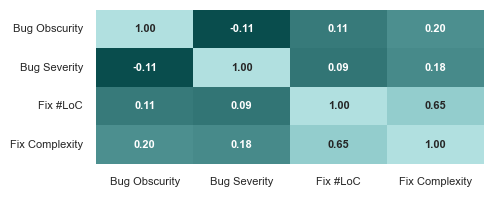

In [62]:
# Convert low, medium, high to 1, 2, 3 for 'Obscurity', 'Impact', '# LOC', and 'Logic Needed'
df_temp = df.copy()
df_temp['Impact'] = df['Impact'].map({'Low': 1, 'Medium': 2, 'High': 3})
df_temp['Obscurity'] = df['Obscurity'].map({'Low': 1, 'Medium': 2, 'High': 3})
df_temp['# LOC'] = df['# LOC'].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})
df_temp['Logic Needed'] = df['Logic Needed'].map({'Low': 1, 'Medium': 2, 'High': 3})

df_temp = df_temp[['Obscurity', 'Impact', '# LOC', 'Logic Needed']]
df_temp = df_temp.dropna()

# rename the columns
df_temp.columns = ['Bug Obscurity', 'Bug Severity', 'Fix #LoC', 'Fix Complexity']

print(df_temp)
print(df_temp.corr())

colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors[5:])

plt.figure(figsize=(5, 2))  # Adjust width and height as needed

# Create the heatmap
heatmap = sns.heatmap(df_temp.corr(),
                       annot=True,
                       annot_kws={"size": 8, "weight": "bold"},
                       cmap=custom_cmap,
                       fmt=".2f",
                       cbar=False)  # Optional: adjust color bar size

# Set the tick labels size and rotation
plt.xticks(fontsize=8, rotation=0)  # X-axis tick labels
plt.yticks(fontsize=8, rotation=0)   # Y-axis tick labels

# Save and show the plot
plt.savefig(SAVE_PATH+'correlation_plot.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [38]:
#About DST Bugs.

temp_df = df[((df['Category 1'] == "DST") | (df['Category 2'] == "DST"))]

#print the length of the dataframe
print("Total number of DST bugs: ", len(temp_df))

category_counts = temp_df['Impact/Severity'].value_counts()
print(category_counts)

plt.figure(figsize=(6, 6))
wedges, labels, autopct_texts = plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 16}  # Adjust the label size here
)

for text in autopct_texts:
    text.set_color('white')
    text.set_fontsize(16)  # Adjust the percentage size here

plt.title('Impact/Severity\n', fontsize=18)
plt.axis('equal')
plt.savefig(SAVE_PATH+'dst_impact_severity.png', transparent=True)
plt.show()

Total number of DST bugs:  12


KeyError: 'Impact/Severity'

### What are the characteristics of each category?
##### Measure of obscurity and impact/severity for each category

{'Datetime Construction': {'Low Obscurity': 27, 'Medium Obscurity': 16, 'High Obscurity': 2, 'Low Impact/Severity': 5, 'Medium Impact/Severity': 35, 'High Impact/Severity': 5}, 'Library Conversions': {'Low Obscurity': 5, 'Medium Obscurity': 3, 'High Obscurity': 0, 'Low Impact/Severity': 1, 'Medium Impact/Severity': 6, 'High Impact/Severity': 1}, 'String Parsing/Formatting (data)': {'Low Obscurity': 11, 'Medium Obscurity': 9, 'High Obscurity': 0, 'Low Impact/Severity': 2, 'Medium Impact/Severity': 16, 'High Impact/Severity': 2}, 'Timezone Conversions': {'Low Obscurity': 18, 'Medium Obscurity': 6, 'High Obscurity': 2, 'Low Impact/Severity': 3, 'Medium Impact/Severity': 18, 'High Impact/Severity': 5}, 'Timestamp/Hash Construction': {'Low Obscurity': 8, 'Medium Obscurity': 2, 'High Obscurity': 0, 'Low Impact/Severity': 0, 'Medium Impact/Severity': 10, 'High Impact/Severity': 0}, 'Datetime Arithmetic': {'Low Obscurity': 2, 'Medium Obscurity': 2, 'High Obscurity': 1, 'Low Impact/Severity': 2

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_48727/1462661391.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(percentages, ha='right')


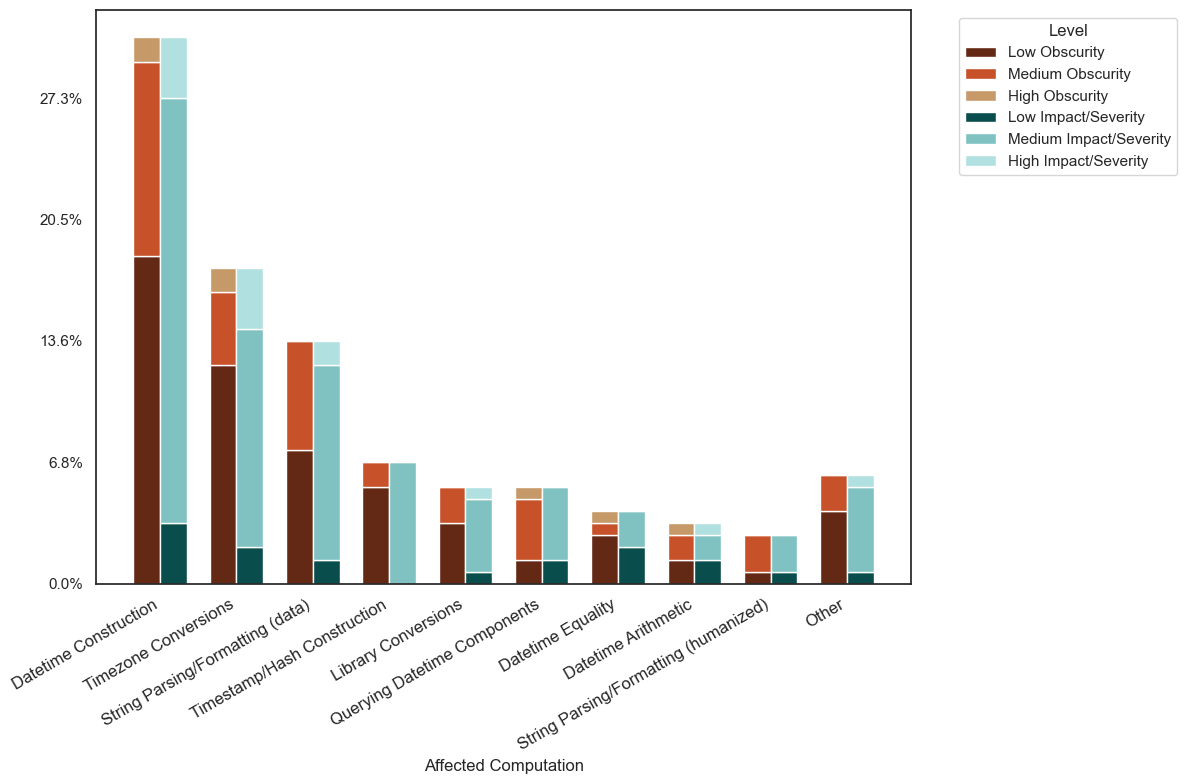

In [ ]:
results = {}

# df = df[(df['Category 1'] == "Timezone") | (df['Category 2'] == "Timezone")]

# Combine unique categories from both columns
categories = pd.concat([df['Erroneous Computation 1'], df['Erroneous Computation 2'], df['Erroneous Computation 3']], axis=0).unique()

# Loop through each unique category
for category in categories:
    # Filter the DataFrame for the current category
    df_category = df[(df['Erroneous Computation 1'] == category) | (df['Erroneous Computation 2'] == category) | (df['Erroneous Computation 3'] == category)]

    # Count the occurrences of each obscurity level
    counts_o = df_category['Obscurity'].value_counts().to_dict()
    counts_s = df_category['Impact/Severity'].value_counts().to_dict()

    # Ensure all levels are included in the result
    results[category] = {
        'Low Obscurity': counts_o.get('Low', 0),
        'Medium Obscurity': counts_o.get('Medium', 0),
        'High Obscurity': counts_o.get('High', 0),
        'Low Impact/Severity': counts_s.get('Low', 0),
        'Medium Impact/Severity': counts_s.get('Medium', 0),
        'High Impact/Severity': counts_s.get('High', 0)
    }

print(results)

# Convert the results dictionary to a DataFrame for better visualization
results_df = pd.DataFrame(results).T
# Convert the results dictionary to a DataFrame for better visualization
results_df = pd.DataFrame(results).T

# Calculate the size of each category
results_df['Total'] = results_df.sum(axis=1)

# Select the top 5 categories by size
top_categories = results_df.nlargest(9, 'Total')

# Select the remaining categories for "Other"
other_categories = results_df.drop(top_categories.index)

# Sum the counts for the "Other" category
other_sums = other_categories.sum()
other_sums.name = 'Other'

# Append the "Other" category to the top categories
top_categories = pd.concat([top_categories, other_sums.to_frame().T])


# Create a grouped bar chart for the top 5 categories + "Other"
categories = top_categories.index
percentages = [f"{float(int(342 * i / 5))/10}%" for i in range(100)]
obscurity_counts = top_categories[['Low Obscurity', 'Medium Obscurity', 'High Obscurity']]
severity_counts = top_categories[['Low Impact/Severity', 'Medium Impact/Severity', 'High Impact/Severity']]

x = pd.Index(range(len(categories)))  # the label locations
width = 0.35  # the width of the bars

# colors = ['#FBFBF2', '#E5E6E4', '#CFD2CD', '#A6A2A2', '#847577', '#615758']
#colors = ['#10A0EC', '#7CC6FE', '#ACD5FF', '#E7BBE3', '#C884A6', '#B25282']
colors = ["#642915", "#c7522a", "#c69a68", "#094d4d", "#80c2c2", "#b1e0e0"]

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, obscurity_counts['Low Obscurity'], width, label='Low Obscurity', color=colors[0])
rects2 = ax.bar(x - width/2, obscurity_counts['Medium Obscurity'], width, bottom=obscurity_counts['Low Obscurity'], label='Medium Obscurity', color=colors[1])
rects3 = ax.bar(x - width/2, obscurity_counts['High Obscurity'], width, bottom=obscurity_counts['Low Obscurity'] + obscurity_counts['Medium Obscurity'], label='High Obscurity', color=colors[2])

rects4 = ax.bar(x + width/2, severity_counts['Low Impact/Severity'], width, label='Low Impact/Severity', color=colors[3])
rects5 = ax.bar(x + width/2, severity_counts['Medium Impact/Severity'], width, bottom=severity_counts['Low Impact/Severity'], label='Medium Impact/Severity', color=colors[4])
rects6 = ax.bar(x + width/2, severity_counts['High Impact/Severity'], width, bottom=severity_counts['Low Impact/Severity'] + severity_counts['Medium Impact/Severity'], label='High Impact/Severity', color=colors[5])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Erroneous Computation')
ax.set_ylabel('')
#ax.set_title('Categories vs Impact/Severity and Obscurity')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=30, ha='right', fontsize=12)
ax.set_yticklabels(percentages, ha='right')
ax.legend(title='Level', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.tight_layout()

plt.show()

fig.savefig(SAVE_PATH+'timezone_affected_computations.png', transparent=True)

### What are the BPSTs associated with each category?
##### Proportion of BPSTs for each category

Color map: ['#642915', '#c7522a', '#d68a58', '#e5c185', '#74a892', '#094d4d', '#80c2c2', '#b1e0e0']


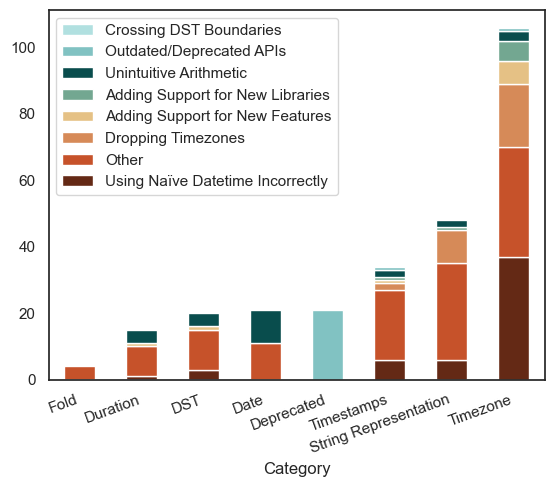

In [ ]:
categories = """Date
DST
Duration
String Representation
Timestamps
Timezone
Fold
Deprecated""".split("\n")

bpsts_short = """Outdated/Deprecated APIs
Using Naïve Datetime Incorrectly
Dropping Timezones
Adding Support for New Features
Unintuitive Arithmetic
Adding Support for New Features
Adding Support for New Libraries
Crossing DST Boundaries
Other""".split("\n")
# only categories listed >=8 times

bpsts = """Incorrect API usage
Outdated/Deprecated APIs
Calling datetime.now() Multiple Times
Using Naïve Datetime Incorrectly
Dropping Timezones
Typo
Subtracting Dates
Adding Support for New Libraries
Adding Support for New Features
Precision of Representation
Library Bug
OOB Timestamps
OOB Datetimes
Creating time in unspecified fold
Crossing DST boundaries
Comparing Timezones
Unintuitive Arithmetic
TODO
Other""".split("\n")

# Figure 2a - Chart bug patterns across each category

bpstmap = {"Category": categories, "total": [0]*len(categories)}
for bpst in bpsts_short:
    bpstmap[bpst] = [0]*len(categories)

for index,row in df.iterrows():
    cats = [row['Category 1'], row['Category 2']]
    indecies = []
    for c in cats:
        if type(c) is str:
            indecies.append(categories.index(c))
    rowbpsts = [row['BPST1'], row['BPST2'], row['BPST3']]
    for bpst in rowbpsts:
        if type(bpst) is str:
            if bpst not in bpsts_short:
                bpst = "Other"
            for i in indecies:
                bpstmap[bpst][i] += 1
                bpstmap["total"][i] += 1

sns.set(style='white')

# colors = ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2','Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b','tab20c']
# colors = "Set2"
# colors = "Dark2"
#colors = "tab20b"
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
print("Color map:", colors)

temp_df = pd.DataFrame(bpstmap).set_index('Category')
temp_df = temp_df.sort_values("total").sort_values("Timezone", ascending=False, axis=1).drop(columns="total")
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
ax = temp_df.plot(kind='bar', legend='reverse', colormap=custom_cmap, stacked=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20,ha='right')

plt.savefig(SAVE_PATH+'fig2.png', transparent=True)

### What are the average impact/severity for each BPST?
##### Number of issues with each BPST, and the proportions of them that have low medium or high impact/severity

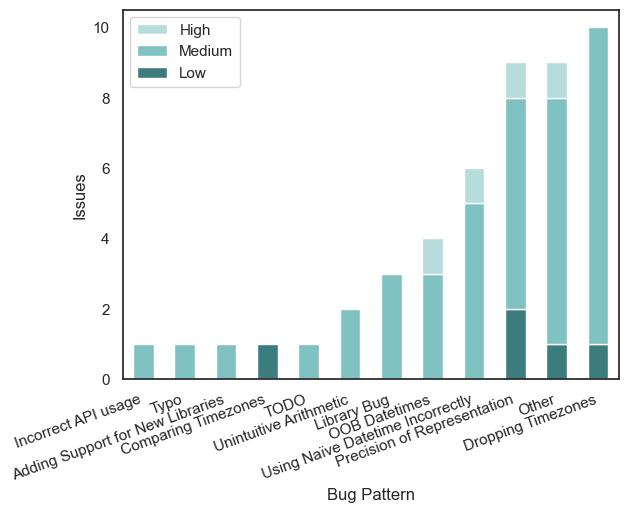

<Figure size 640x480 with 0 Axes>

In [ ]:
# Figure 2b - Chart severity across bpst for string rep

df_sr = df[(df['Category 1'] == 'String Representation') | (df['Category 2'] == 'String Representation')]


ratings = ["Low", "Medium", "High"]
temp_data = {"Bug Pattern": bpsts, "total": [0]*len(bpsts)}
for r in ratings:
    temp_data[r] = [0]*len(bpsts)

for index, row in df_sr.iterrows():
    rowbpsts = [row['BPST1'], row['BPST2'], row['BPST3']]
    for bpst in rowbpsts:
        if type(bpst) is str:
            bpst = bpst if bpst in bpsts else "Other"
            val = row["Impact/Severity"]
            temp_data[val][bpsts.index(bpst)] += 1
            temp_data["total"][bpsts.index(bpst)] += 1


temp_df = pd.DataFrame(temp_data).set_index('Bug Pattern')
temp_df = temp_df.loc[temp_df['total'] !=0]
temp_df = temp_df.sort_values("total").drop(columns="total")
#temp_df = temp_df.drop("TODO")

#colors = ['#0a00b3', '#346bcc', '#00a9ec']
# colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
# custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors[1:4])
colors = ["#3C7C7C", "#80c2c2", "#B6DCDC"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

ax = temp_df.plot(kind='bar', legend='reverse', colormap=custom_cmap, stacked=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20,ha='right')
ax.set_ylabel("Issues")

# rects = ax.patches
# print(rects)

# Make some labels.
# labels = [f"label{i}" for i in range(len(rects))]

# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(
#         rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
#     )

plt.show()

plt.savefig(SAVE_PATH+'fig2-1.png', transparent=True)

### What is the distribution of logic and impact/severity levels for datetime construction (Erroneous Computation) issues?

##### Logic levels and impact/severity levels for datetime construction issues in Erroneous Computations

In [57]:
#Datetime Construction
df = df.reset_index(drop=True)

df_TZ = df[(df['Category 1'] == "Time zone") | (df['Category 2'] == "Time zone")]

# print(df_TZ['Erroneous Computation 1'])

df_TZ_cn = df_TZ[(df_TZ['Erroneous Computation 1'] == "Datetime Construction") | (df_TZ['Erroneous Computation 2'] == "Datetime Construction") | (df_TZ['Erroneous Computation 3'] == "Datetime Construction")]
# df_TZ_cn

logic_data = {}
impact_data = {}

logic_data['Low'] = df_TZ_cn['Logic Needed'].value_counts().get('Low', 0)
logic_data['Medium'] = df_TZ_cn['Logic Needed'].value_counts().get('Medium', 0)
logic_data['High'] = df_TZ_cn['Logic Needed'].value_counts().get('High', 0)


impact_data['Low'] = df_TZ_cn['Impact'].value_counts().get('Low', 0)
impact_data['Medium'] = df_TZ_cn['Impact'].value_counts().get('Medium', 0)
impact_data['High'] = df_TZ_cn['Impact'].value_counts().get('High', 0)

#colors = ['#10A0EC', '#7CC6FE', '#ACD5FF', '#E7BBE3', '#C884A6', '#B25282']
colors = ["#E7A590", "#D66640", "#B84B27", "#3C7C7C", "#80c2c2", "#B6DCDC"]

# Create pie chart for logic levels
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(logic_data.values(), labels=logic_data.keys(), autopct='%1.1f%%', startangle=140, colors=colors[0:3])
plt.title('Logic Levels')

# Create pie chart for impact/severity levels
plt.subplot(1, 2, 2)
plt.pie(impact_data.values(), labels=impact_data.keys(), autopct='%1.1f%%', startangle=140, colors=colors[3:6])
plt.title('Impact/Severity Levels')

plt.tight_layout()
plt.savefig(SAVE_PATH+'fig1-1_datetime.png', transparent=True)
plt.show()



/Users/smtiwari/Library/Python/3.9/lib/python/site-packages/matplotlib/axes/_axes.py:3229: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 1000x500 with 1 Axes>

### How is each characteristic correlated?
##### Correlation graph for impact, obscurity, LOC, and logic needed

     Obscurity  Impact  # LOC  Logic Needed
0            1       1      1             1
1            1       2      2             3
2            2       2      2             1
3            1       1      1             1
4            1       1      1             1
..         ...     ...    ...           ...
147          1       2      1             1
148          2       2      3             2
149          1       1      2             1
150          2       1      2             2
151          3       1      1             1

[152 rows x 4 columns]
              Obscurity    Impact     # LOC  Logic Needed
Obscurity      1.000000 -0.108201  0.105507      0.203582
Impact        -0.108201  1.000000  0.085241      0.181545
# LOC          0.105507  0.085241  1.000000      0.654124
Logic Needed   0.203582  0.181545  0.654124      1.000000


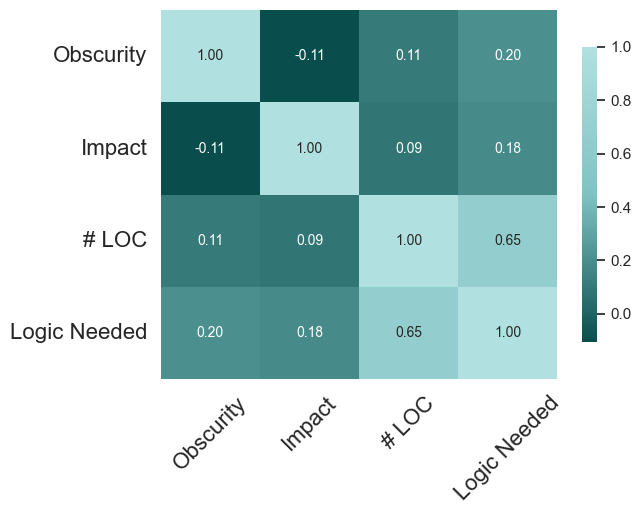

In [17]:
# Convert low, medium, high to 1, 2, 3 for 'Obscurity', 'Impact', '# LOC', and 'Logic Needed'
df_temp = df.copy()
df_temp['Impact'] = df['Impact'].map({'Low': 1, 'Medium': 2, 'High': 3})
df_temp['Obscurity'] = df['Obscurity'].map({'Low': 1, 'Medium': 2, 'High': 3})
df_temp['# LOC'] = df['# LOC'].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})
df_temp['Logic Needed'] = df['Logic Needed'].map({'Low': 1, 'Medium': 2, 'High': 3})

df_temp = df_temp[['Obscurity', 'Impact', '# LOC', 'Logic Needed']]
df_temp = df_temp.dropna()
print(df_temp)
print(df_temp.corr())

colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors[5:])

# Create the heatmap
heatmap = sns.heatmap(df_temp.corr(),
                       annot=True,
                       annot_kws={"size": 10},  # Set the font size for annotations
                       cmap=custom_cmap,
                       fmt=".2f",
                       cbar_kws={'shrink': .8})  # Optional: adjust color bar size

# Set the tick labels size and rotation
plt.xticks(fontsize=16, rotation=45)  # X-axis tick labels
plt.yticks(fontsize=16, rotation=0)   # Y-axis tick labels

# Save and show the plot
plt.savefig(SAVE_PATH+'correlation_plot.pdf', transparent=True, bbox_inches='tight')
plt.show()

# LOC
Medium       68
Low          56
High         15
Very High    13
Name: count, dtype: int64
<class 'pandas.core.series.Series'>


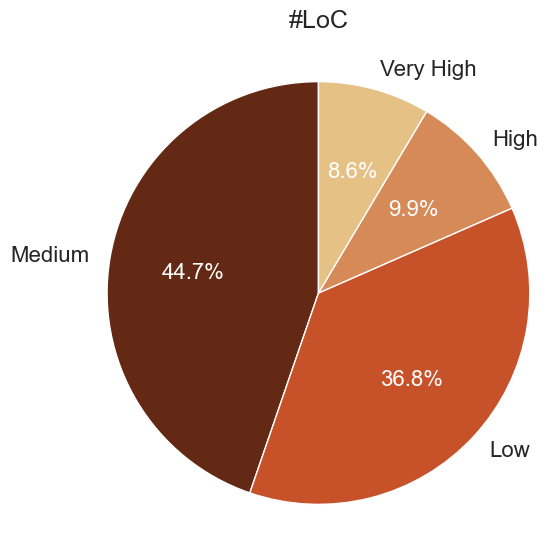

Logic Needed
Low       85
Medium    51
High      16
Name: count, dtype: int64


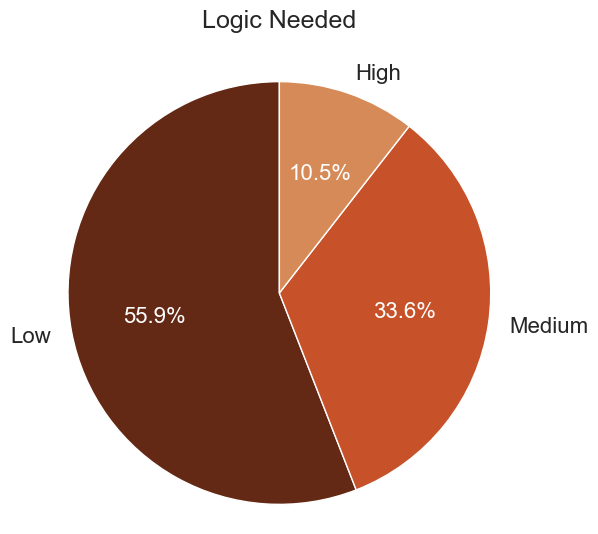

Obscurity
Low       91
Medium    48
High      13
Name: count, dtype: int64


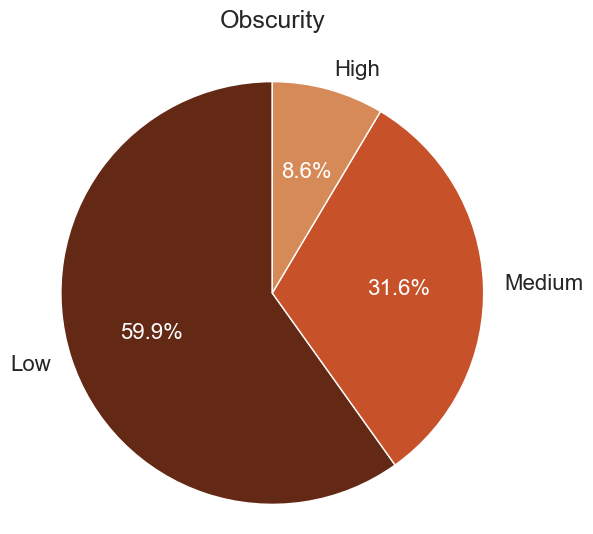

In [54]:
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]

# Q1
category_counts = df['# LOC'].value_counts()
print(category_counts)
print(type(category_counts))

plt.figure(figsize=(6, 6))
wedges, labels, autopct_texts = plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 16}  # Adjust the label size here
)

for text in autopct_texts:
    text.set_color('white')
    text.set_fontsize(16)  # Adjust the percentage size here

plt.title('#LoC\n', fontsize=18)  # Adjust the title size here
plt.axis('equal')
plt.savefig(SAVE_PATH+'bugs_localized.png', transparent=True)
plt.show()


# Q2
category_counts = df['Logic Needed'].value_counts()
print(category_counts)

plt.figure(figsize=(6, 6))
wedges, labels, autopct_texts = plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 16}  # Adjust the label size here
)

for text in autopct_texts:
    text.set_color('white')
    text.set_fontsize(16)  # Adjust the percentage size here

plt.title('Logic Needed\n', fontsize=18)  # Adjust the title size here
plt.axis('equal')
plt.savefig(SAVE_PATH+'bugs_logic_needed.png', transparent=True)
plt.show()


# Q3
category_counts = df['Obscurity'].value_counts()
print(category_counts)

plt.figure(figsize=(6, 6))
wedges, labels, autopct_texts = plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 16}  # Adjust the label size here
)

for text in autopct_texts:
    text.set_color('white')
    text.set_fontsize(16)  # Adjust the percentage size here

plt.title('Obscurity\n', fontsize=18)  # Adjust the title size here
plt.axis('equal')
plt.savefig(SAVE_PATH + 'bugs_obscurity.png', transparent=True)
plt.show()